# CS-502 Homework 2: Graph Neural Networks

Author: Mika Senghaas (mika.senghaas@epfl.ch)

This homework assignment implements a custom **graph neural network** (GNN) in pure [Pytorch](https://pytorch.org) and perform experiments on the [MUTAG]() dataset for graph classficiation of chemcical compounds. MUTAG consists of a collection of chemcical compounds, each represented as a graph. Here, *nodes* are atoms and identified by the atom type, *edges* are chemical bounds between the atoms with features indicating the chemical bond type. Each graph represents a chemical compound and is labelled as either *mutagenic* (positive) or *non-mutagenic* (negative) class. 

This notebook implements a graph neural network, which will be used in experiments to build a high-quality binary classifier for the mutagenicitiy of a chemical compound.

## Imports & Setup

We import the necessary modules and set global parameters. Note, that this notebook was run in the lastest minor release of Python `3.9`.

In [1]:
# Standard library
import os
import sys
import time
import uuid
import json
import random
from itertools import product
from collections import Counter
from typing import Union

# External libraries
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
print(sys.version)

3.9.16 (main, Dec 16 2022, 22:25:05) 
[Clang 14.0.0 (clang-1400.0.29.202)]


In [3]:
# Global variables
BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, 'data', 'mutag.jsonl')
PLOT_PATH = os.path.join(BASE_PATH, 'plots')

# Flag to train the model
TRAIN = False

# Check if data exists and is in the right place
assert os.path.exists(DATA_PATH), f'❌ Error: Please download the data and place it in {DATA_PATH}'

# Create data path if it doesn't exist
os.makedirs(PLOT_PATH, exist_ok=True)

In [4]:
# Set seed for reproducibility
random.seed(1)
torch.manual_seed(1)

# Set plot styles
sns.set_style("darkgrid")

# Set float precision for pandas
pd.set_option("display.precision", 2)

# Test data
test_x = torch.eye(3)
test_adj = torch.randint(0, 2, (3, 3)).float()
test_e = torch.randint(0, 2, (3, 3, 4)).float()

In [5]:
class Meta(type):
    def __repr__(cls):
        return cls.__name__

## Part 1: Implementing Different Graph Convolution and Pooling Layers

---

### Normal Convolution (Graph Convolution)

A regular graph convolution in the $l$-th layer computes the embedding of the $v$-th node, $\mathbf{h}_v$ through

$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \sum_{u\in N(v)} \frac{\mathbf{h}_u^{(l)}}{|N(v)|} + \mathbf{B}_l \mathbf{h}_v^{(l)} \right).
$$

Note, that here $\sigma$ is a non-linearity, $\mathbf{W}_l$ and $\mathbf{B}_l$ are both trainable weight matrices with dimension 
$\text{in\_features} \times \text{out\_features}$ and $N(v)$ is the set of adjacent nodes in the graph.

We can represent the average over the neighbourhood of node $v$ through a matrix product of the adjacency matrix $\mathbf{A}$ with the matrix $\mathbf{H}^{(l)}=\left[\mathbf{h}^{(l)}_1, ..., \mathbf{h}^{(l)}_{|V|}\right]$ holding all node embeddings in the $l$ layer (corrected by the inverse of the degree $\tilde{A}$ to obtain an average) as

$$
H^{(l+1)} = \sigma\left( \tilde{A}H^{(l)}W_l^\top + H^{(l)}B_l^\top \right).
$$

In [6]:
class GraphConv(nn.Module, metaclass=Meta):
    """Basic graph convolutional layer implementing the simple neighborhood aggregation."""

    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the graph convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        
        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layers
        torch.manual_seed(0)
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.bias = nn.Linear(in_features, out_features, bias=False)

        # Non-linear activation function (optional)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # Neighbourhood aggregation
        adj = adj / adj.sum(1, keepdim=True).clamp(1)
        x_agg = adj @ x

        # Graph convolution
        x = self.weight(x_agg) + self.bias(x)

        # Apply non-linear activation if specified
        if self.activation:
            return self.activation(x)
        return x

In [7]:
# Test graph convolution
conv = GraphConv(3, 2)
out = conv(test_x, test_adj)

assert out.shape == (3, 2), f"Output shape shold be 3x2 but is {out.shape}"
assert repr(GraphConv) == "GraphConv", f"Class name should be `GraphConv`, but is {repr(GraphConv)}"

print("Tests passed. ✅")

Tests passed. ✅


### GraphSAGE (Customised Aggregation)

GraphSAGE is a generalised version of the regular graph convolution, in which any type of aggregation can be applied to. Instead of adding the result of two matrix products and performing a non-linearity, here the original node embeddings are concatenated with the aggregated neighbourhood embeddings and then linearly transformed. The equation for the GraphSAGE layer is:

$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \cdot \mathrm{CONCAT} \left[\mathbf{h}_v^{(l)}, \mathrm{AGG} \left(\left\{\mathbf{h}_u^{(l)}, \forall u\in N(v) \right\}\right) \right] \right),
$$

where $v$ index the node, $l$ the layer, $\mathbf{h}$ are the node embeddings, $\sigma$ is a non-linearity, $N(v)$ is the set of neighbor of node $v$, and $\mathbf{W}$ is the trainable weight matrix of the layer. $\mathrm{CONCAT}$ is the concatenation operation, while $\mathrm{AGG}$ is an arbitrary aggregation function.

In [8]:
# Aggregations
class MeanAggregation(nn.Module):
    """Aggregate node features by averaging over the neighborhood."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        x_agg = adj / adj.sum(1, keepdim=True).clamp(1)

        return x_agg @ x
    
class SumAggregation(nn.Module):
    """Aggregate node features by summing over the neighborhood."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        return adj @ x

In [9]:
class GraphSAGEConv(nn.Module, metaclass=Meta):
    """GraphSAGE convolutional layer."""
    
    def __init__(self, 
        in_features, 
        out_features, 
        aggregation=SumAggregation,
        activation=None):
        """
        Initialize the GraphSAGE convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            aggregation (nn.Module or callable): aggregation function to apply, as x_agg = aggegration(x, adj).
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()

        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layer (no bias)
        torch.manual_seed(0)
        self.weight = nn.Linear(2*in_features, out_features, bias=False)

        # Aggregation function
        self.aggregation = aggregation()

        # Non-linear activation function (optional)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (batch_dim, num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # Neighbourhood aggregation
        x_agg = self.aggregation(x, adj)

        # Concatenate node features and aggregated features
        x_cat = torch.cat([x, x_agg], dim=1)
        
        # Apply linear transformation
        x = self.weight(x_cat)

        # Apply non-linear activation if specified
        if self.activation:
            return self.activation(x)
        return x

In [10]:
# Test GraphSAGE
conv = GraphSAGEConv(3, 2, aggregation=MeanAggregation)
out = conv(test_x, test_adj)

assert out.shape == (3, 2), f"Output shape shold be 3x2 but is {out.shape}"
assert repr(GraphSAGEConv) == "GraphSAGEConv", f"Class name should be `GraphSAGEConv`, but is {repr(GraphSAGEConv)}"

print("Tests passed. ✅")

Tests passed. ✅


### Attention-based Convolution



In [11]:
class AttentionGraphConvolution(nn.Module, metaclass=Meta):
    """Attention-based convolutional layer."""
    
    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the attention-based convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()

        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layer (no bias)
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.att = nn.Linear(2*out_features, 1, bias=False)

        # Non-linear activation function (optional)
        self.leaky_relu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim=1)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform an attention-based graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """

        # Linear transformation 
        x = self.weight(x)

        # Add self-loops to the adjacency matrix
        adj = torch.minimum(
            adj + torch.eye(adj.shape[0]), 
            torch.ones_like(adj))

        # Attention weights
        v = len(adj)
        u_indices = torch.cat([
            torch.fill(torch.empty(v), i).long() 
            for i in torch.arange(v)])
        v_indices = torch.arange(v).repeat(v)

        cc = torch.cat([x[u_indices], x[v_indices]], dim=1)
        att = self.leaky_relu(self.att(cc).reshape(v, v))

        # Normalise attention weights via softmax on neighbours
        adj_mask = torch.where(adj > 0, torch.zeros_like(adj), torch.full_like(adj, -torch.inf))
        att = att + adj_mask
        att = self.softmax(att)

        # Attention-based aggregation
        x = att @ x
        
        # Apply non-linear activation if specified 
        if self.activation:
            return self.activation(x)
        return x

In [12]:
# Test attention-based convolution
conv = AttentionGraphConvolution(3, 2)
out = conv(test_x, test_adj)

assert out.shape == (3,2), f"Output shape shold be 3x2 but is {out.shape}"
assert repr(AttentionGraphConvolution) == "AttentionGraphConvolution", f"Class name should be `AttentionGraphConvolution`, but is {repr(AttentionGraphConvolution)}"

print(f"Tests passed. ✅")

Tests passed. ✅


### Mean Pooling

Mean pooling computes a graph level representation $\mathbf{h}_{\text{global}}$ as the mean (average) of all node features

$$
\textbf{h}_{\text{global}} = \frac{1}{N} \sum_{i=1}^N \mathbf{X}_i,
$$

where $\mathbf{X} \in \mathbb{R}^{N \times D}$ where $N$ is the number of nodes and $D$ is the feature dimension. Finally, $\mathbf{X}_i$ is node representation of the $i$-th node.

In [13]:
class MeanPooling(nn.Module, metaclass=Meta):
    """Mean pooling layer."""

    def __init__(self):
        """Initialize mean pooling layer."""
        super().__init__()

    def forward(self, x):
        """
        Computes the average of all node features.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).

        Returns:
            Tensor: Aggregated node features of shape (in_features).
        """
        return torch.mean(x, dim=0)

In [14]:
# Simple test
x = torch.arange(12).reshape(4, 3).float()
meanpool = MeanPooling()
out = meanpool(x)

assert out.shape == (3,), "Output shape should be (3, ), but is {out.shape}"
assert torch.equal(out, torch.Tensor([4.5, 5.5, 6.5])), f"Output should be torch.Tensor([9, 10, 11]), but is {out}"
assert repr(MeanPooling) == "MeanPooling", f"Class name should be MaxPooling, but is {repr(MeanPooling)}"

print("Tests passed. ✅")

Tests passed. ✅


### Max Pooling

Max pooling computes a graph level representation $\mathbf{h}_{\text{global}}$ by taking the maximum value from each feature dimension across all nodes in the graph-level representation

$$
\textbf{h}_{\text{global}, d} =  \max_{i=1}^N \mathbf{X}_{i, d}
$$

for each feature dimension $d$ and again $\mathbf{X} \in \mathbb{R}^{N \times D}$ where $N$ is the number of nodes and $D$ is the feature dimension and $\mathbf{X}_i$ is node representation of the $i$-th node.

In [15]:
class MaxPooling(nn.Module, metaclass=Meta):
    """Max pooling layer."""

    def __init__(self):
        """Initialize mean pooling layer."""
        super().__init__()

    def forward(self, x):
        """
        Computes the max pool of all node features.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).

        Returns:
            Tensor: Max pooled node features of shape (in_features,).
        """

        return torch.max(x, dim=0).values

In [16]:
# Simple test
x = torch.arange(12).reshape(4, 3)
maxpool = MaxPooling()
out = maxpool(x)

assert out.shape == (3,), f"Output shape should be (3,), but is {out.shape}"
assert torch.equal(out, torch.arange(9, 12)), f"Output should be torch.Tensor([9, 10, 11]), but is {out}"
assert repr(MaxPooling) == "MaxPooling", f"Class name should be MaxPooling, but is {repr(MaxPooling)}"

print("Tests passed. ✅")

Tests passed. ✅


## Part 2: Custom Network Design with Node Features

---

### Custom Network Architecture

This is a generic graph neural network for binary graph classification. It can be composed of the modules from above that can through user parameters for the number of node features as input, type and number of graph convolutional layers, pooling mechanism, dropout and batch normalisation.

In [17]:
class GNN(nn.Module):
    """Custom graph neural network model for binary graph prediction."""

    def __init__(self, 
        num_features: int, 
        conv_dims: list[int], 
        conv: nn.Module = GraphConv, 
        pooling: nn.Module = MeanPooling, 
        activation: nn.Module or callable = nn.LeakyReLU, 
        dropout=0.,
        ):
        """
        Initialize the GNN model for graph prediction.

        Args:
            num_features (int): Number of input node features.
            conv_dims (list of int): Number of hidden features in each graph convolution layers.
            activation (nn.Module or callable): Activation function to apply.
            dropout (float): Dropout probability. (optional)
        """
        super().__init__()

        # Create UUID
        self.uuid = uuid.uuid4().hex
        
        # Save parameters
        self.dropout = dropout

        # Compute dimensions and activations for graph conv layers
        dimensions = [num_features] + conv_dims
        in_dimensions = dimensions[:-1]
        out_dimensions = dimensions[1:]
        activations = [activation] * (len(conv_dims) - 1) + [None]

        # Create Graph convolution layers
        self.convs = nn.ModuleList([
            conv(
                in_features, 
                out_features,
                activation=activation() if activation else activation
            ) for in_features, out_features, activation in 
            zip(in_dimensions, out_dimensions, activations)
        ])

        """
        # Batch norm layers
        self.norms = nn.ModuleList()
        for dim in conv_dims:
            self.norms.append(nn.BatchNorm1d(dim))
        """
        
        # Pooling layer
        self.pooling = pooling()

        # Fully connected layer
        self.fc = nn.Linear(conv_dims[-1] if conv_dims else num_features, 1)


    def forward(self, x, adj):
        """
        Perform forward pass for graph prediction.

        Args:
            x (Tensor): Input node features of shape (num_nodes, num_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).
        """

        # Graph convolution layers
        for conv in self.convs:
            x = F.dropout(conv(x, adj), p=self.dropout)

        # Pooling layer
        x = self.pooling(x)

        # Fully connected layer
        x = self.fc(x)

        return x

In [18]:
# Test architecture
model = GNN(3, [4, 4])
logits = model(test_x, test_adj)

assert logits.shape == (1,), f"Expected shape (1,), but got {logits.shape}"
print("Tests passed. ✅")

Tests passed. ✅


### Data Loading and Partitioning

This section loads and partitions the input data using the utility classes `torch.utils.data.Dataset` and `torch.utils.data.RandomDataSampler` to create random (but seeded) partitioning into training (70%), validation (15%) and testing (15%).

In [19]:
# Load the dataset
class MUTAGDataset(Dataset):
    def __init__(self, datapath: str):
        super().__init__()

        with open(datapath, "r") as f:
            raw = f.read()
        
        self.graphs = [json.loads(line) for line in raw.splitlines()]

    def __len__(self):
        """
        Returns the number of graphs in the dataset
        """
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Returns a single graph's node features, edge features, adjacency matrix and label

        Args:
            idx (int): Index of the graph to return.

        Returns:
            Tensor: Node features of shape (num_nodes, num_features).
            Tensor: Adjacency matrix of shape (num_nodes, num_nodes).
        """
        graph = self.graphs[idx]

        # Create adjacency matrix
        n = graph["num_nodes"]
        adj = torch.zeros((n, n))
        d_edges = len(graph["edge_attr"][0])
        edge_attr = torch.zeros((n, n, d_edges))
        for idx, (i, j) in enumerate(zip(graph["edge_index"][0], graph["edge_index"][1])):
            adj[i, j] = 1
            adj[j, i] = 1
            edge_attr[i, j] = torch.Tensor(graph["edge_attr"][idx])
            edge_attr[j, i] = torch.Tensor(graph["edge_attr"][idx])

        node_feat = torch.Tensor(graph["node_feat"])
        label = torch.Tensor(graph["y"])

        return node_feat, edge_attr, adj, label

In [20]:
# Test dataset class
data = MUTAGDataset(datapath=DATA_PATH)
node_feat, edge_attr, adj, label = data[0]

assert node_feat.shape == (17, 7), f"Expected 17 nodes with 7 node features, but got {node_feat.shape}"
assert edge_attr.shape[:2] == adj.shape, f"Edge attribute shape should be (17, 17), but is {edge_attr.shape}"

print("Tests passed. ✅")

Tests passed. ✅


In [21]:
def convert_to_graph(data: tuple) -> nx.Graph:
    """
    Converts a single graph from its tensor representation to a networkx graph.
    
    Args:
        data (tuple): Tuple of node features, edge features, adjacency matrix and label.

    Returns:
        nx.Graph: Networkx graph.
    """
    # Unpack data
    n, e, adj, label = data
    node_types = {i: node_type.item() for i, node_type in enumerate(torch.argmax(n, dim=1))}
    
    # List of tuples of edge indices
    edge_index = adj.nonzero().t().contiguous()
    edge_index = [tuple(edge) for edge in edge_index.t().tolist()]

    # List of edge labels (encode as -1 if no edge)
    neg_edges = torch.sum(e, dim=2) == 0
    masked_edge_labels = torch.where(neg_edges, -1, torch.argmax(e, dim=2))
    edge_labels = [edge_label.item() for edge_label in masked_edge_labels.flatten() if edge_label.item() != -1]
    edge_types = {(i, j): edge_type for (i,j), edge_type in zip(edge_index, edge_labels)}

    # Build graph and add node and edge features
    G = nx.from_numpy_array(adj.numpy())
    G.name = label.item()
    nx.set_node_attributes(G, node_types, "node_type")
    nx.set_edge_attributes(G, edge_types, "edge_type")

    return G

In [22]:
def plot_graph(graph: nx.Graph, ax=None) -> None:
    """
    Plot a single graph with node and edge labels. The node colours represent
    the class of the graph (mutagenic or not).

    Args:
        graph (nx.Graph): Networkx graph.
        ax (matplotlib.axes.Axes): Axes to plot on. (optional)

    Returns:
        None
    """

    # Styles
    colors = ["lightblue", "red"]
    styles = {
        "node_size": 100,
        "edge_color": "grey",
        "with_labels": True,
        "font_size": 8,
    }

    pos = nx.spring_layout(graph)
    nx.draw(
        graph, 
        pos=pos, 
        node_color=colors[int(graph.name)],
        labels=nx.get_node_attributes(graph, "node_type"),
        ax=ax,
        **styles,
    )

    nx.draw_networkx_edge_labels(
        graph, 
        pos=pos, 
        edge_labels=nx.get_edge_attributes(graph, "edge_type"),
        font_size=8,
        ax=ax
    )

    ax.set_title(f"Class: {int(graph.name)}")

In [23]:
def plot_categorical_dist(x: list, hue: Union[list, None] = None, title: Union[str, None] = None, ax=None) -> None:
    """
    Plot the distribution of a categorical variable.

    Args:
        x (dict): Dictionary of class counts.
        title (str): Title of the plot. (optional)
        ax (matplotlib.axes.Axes): Axes to plot on. (optional)

    Returns:
        None
    """
    if ax is None:
        _, ax = plt.subplots()
    sns.countplot(x=x, hue=hue, ax=ax, stat="count")
    ax.set(
        xlabel="Class",
        ylabel="Count",
        title="Distribution of classes" if title is None else title,
    )

In [24]:
def compute_graph_statistics(graphs: list[nx.Graph]) -> None:
    """
    Print some basic statistics about a set of graphs.

    Args:
        graphs (list of nx.Graph): List of graphs.

    Returns:
        dict: Dictionary of graph statistics.
    """
    # Number of graphs
    num_graphs = len(graphs)

    # Average number of nodes and edges
    avg_num_nodes = sum([graph.number_of_nodes() for graph in graphs]) / num_graphs
    avg_num_edges = sum([graph.number_of_edges() for graph in graphs]) / num_graphs
    compute_avg_degree = lambda graph: sum(dict(graph.degree).values()) / len(graph.degree)
    avg_degree = sum([compute_avg_degree(graph) for graph in graphs]) / num_graphs
    full_connectivity = sum([nx.is_connected(graph) for graph in graphs]) / num_graphs
    
    # Class distribution
    classes = [int(graph.name) for graph in graphs]
    class_dist = Counter(classes)
    pos_ratio = class_dist[1] / num_graphs

    # Node type distribution
    node_types = [node_type for graph in graphs for node_type in nx.get_node_attributes(graph, "node_type").values()]
    node_type_dist = Counter(node_types)

    # Edge type distribution
    edge_types = [edge_type for graph in graphs for edge_type in nx.get_edge_attributes(graph, "edge_type").values()]
    edge_type_dist = Counter(edge_types)

    return {
        "#Graphs": num_graphs,
        "Avg. #Nodes": avg_num_nodes,
        "Avg. #Edges": avg_num_edges,
        "Avg. Degree": avg_degree,
        "Full Connectivity": full_connectivity,
        "Positive Ratio": pos_ratio,
        "Classes": classes,
        "Class Distribution": class_dist,
        "Node Types": node_types,
        "Node Type Distribution": node_type_dist,
        "Edge Types": edge_types,
        "Edge Type Distribution": edge_type_dist,
    }

In [25]:
def display_statistics(*statistics: list[dict], index: list[str]) -> pd.DataFrame:
    columns = ["#Graphs", "Avg. #Nodes", "Avg. #Edges", "Avg. Degree", "Full Connectivity", "Positive Ratio"]
    return pd.DataFrame(statistics, index=index)[columns].T

In [26]:
# Save all graphs in a list
all_graphs = [convert_to_graph(data[idx]) for idx in range(len(data))]

# Save positive and negative examples in separate lists
positive_graphs = [graph for graph in all_graphs if graph.name == 1]
negative_graphs = [graph for graph in all_graphs if graph.name == 0]

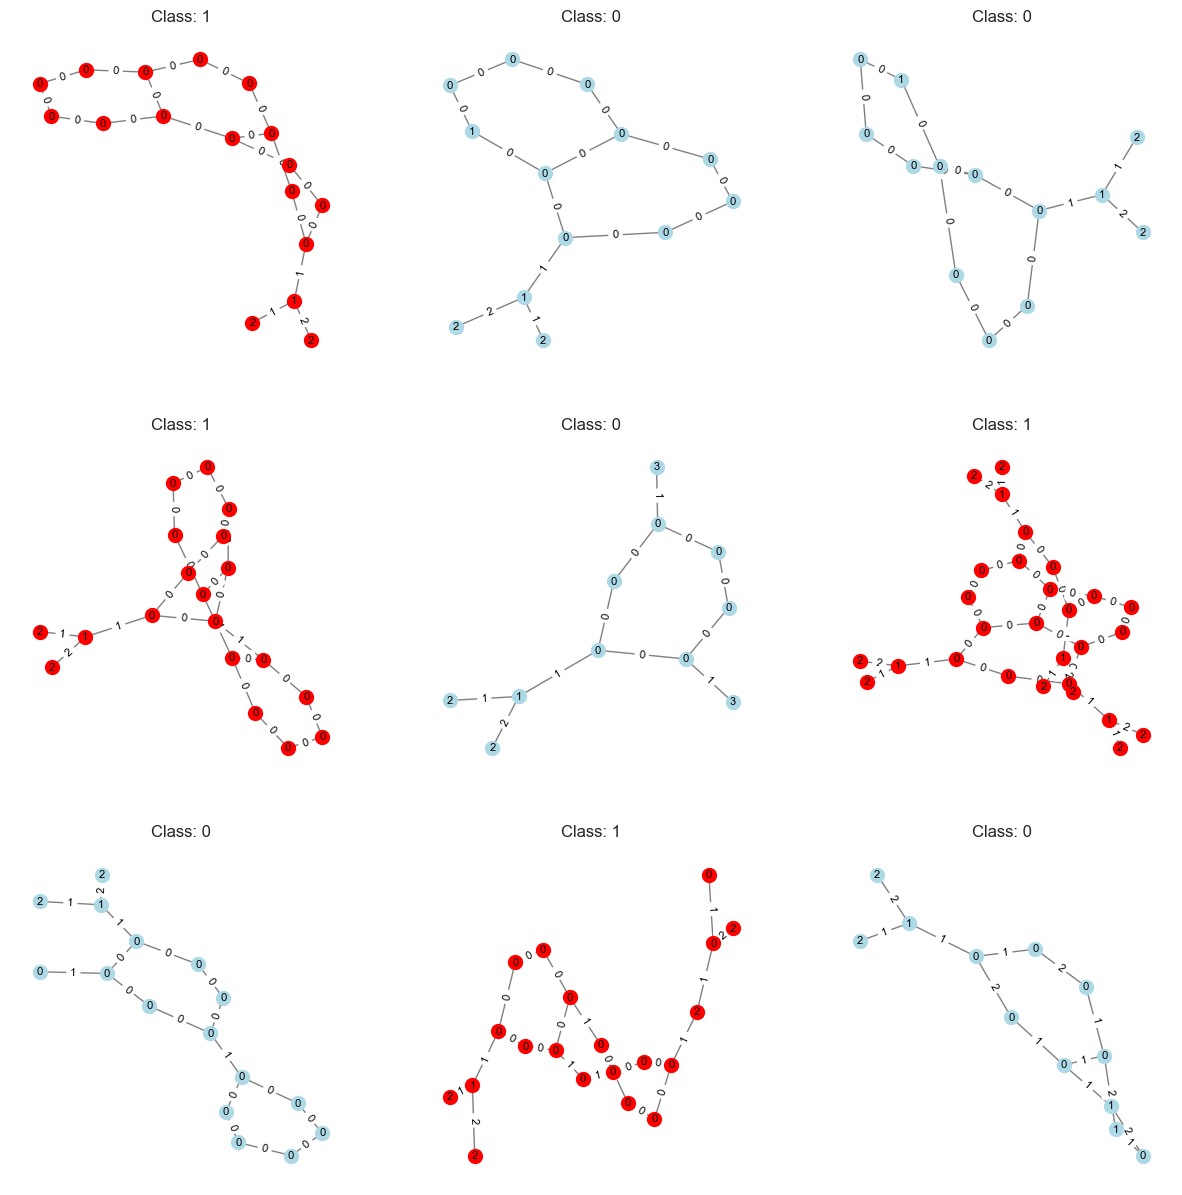

In [27]:
# View the dataset
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    # Draw with node colour and edge colour encoding node and edge types
    plot_graph(all_graphs[i], ax=ax[i//3, i%3])

fig.savefig(os.path.join(PLOT_PATH, "dataset.png"), dpi=300)

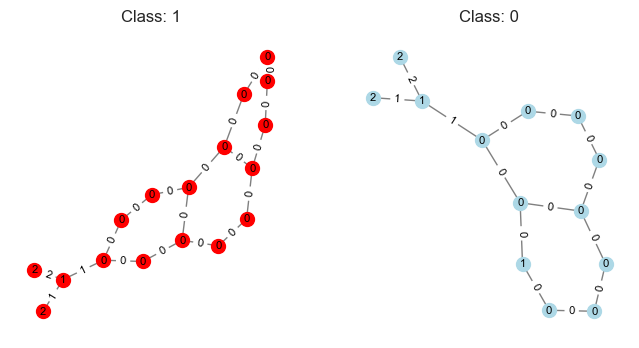

In [28]:
# Print positive vs. negative sample side-by-side
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
plot_graph(positive_graphs[0], ax=ax[0])
plot_graph(negative_graphs[0], ax=ax[1])

# Save figure
fig.savefig(os.path.join(PLOT_PATH, "pos_vs_neg.png"))

,MUTAG
#Graphs,188.00
Avg. #Nodes,17.93
Avg. #Edges,19.79
Avg. Degree,2.19
Full Connectivity,1.00
Positive Ratio,0.66


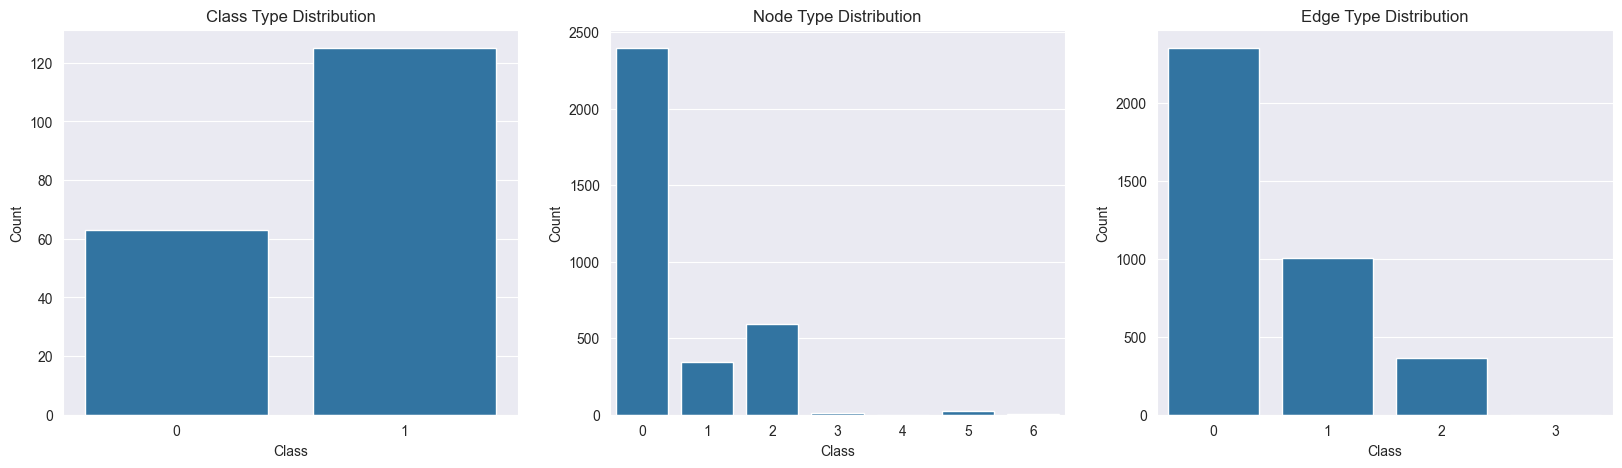

In [29]:
# Print some basic statistics about the dataset
statistics = compute_graph_statistics(all_graphs)

# Plot class, node type and edge type distribution
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
plot_categorical_dist(statistics["Classes"], ax=ax[0], title="Class Type Distribution")
plot_categorical_dist(statistics["Node Types"], ax=ax[1], title="Node Type Distribution")
plot_categorical_dist(statistics["Edge Types"], ax=ax[2], title="Edge Type Distribution")

# Save plot
fig.savefig(os.path.join(PLOT_PATH, "mutag_statistics.png"), dpi=300)

display_statistics(statistics, index=["MUTAG"])

,Positive,Negative
#Graphs,125.00,63.00
Avg. #Nodes,19.94,13.94
Avg. #Edges,22.40,14.62
Avg. Degree,2.24,2.09
Full Connectivity,1.00,1.00
Positive Ratio,1.00,0.00


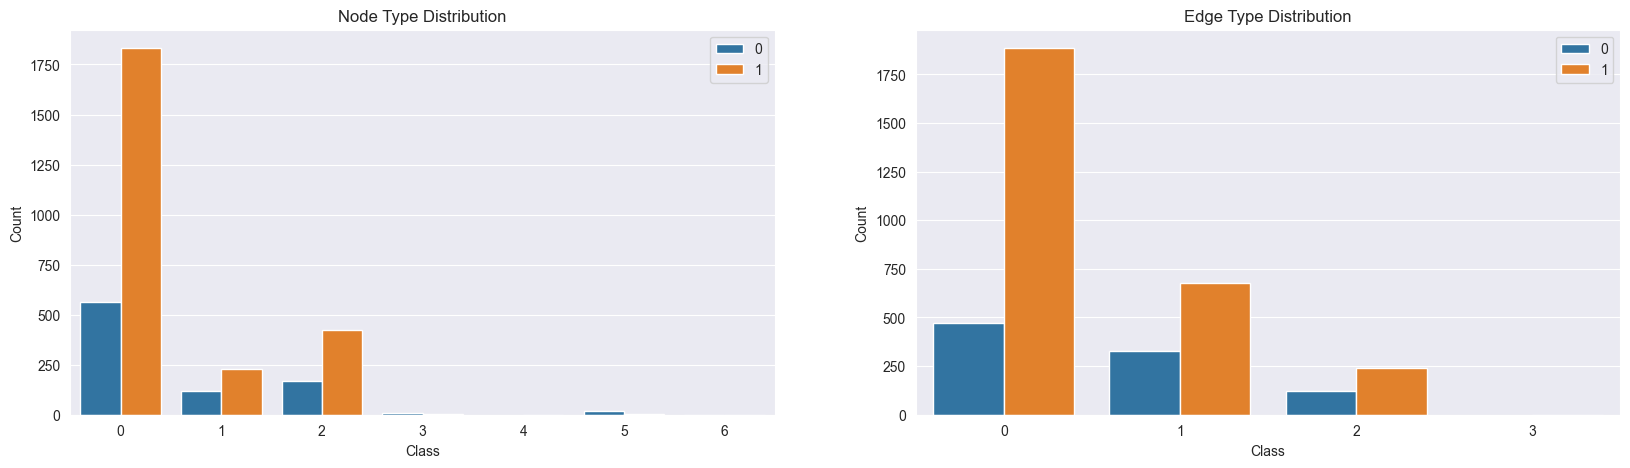

In [30]:
# Print some basic statistics about the positive and negative graphs
pos_statistics = compute_graph_statistics(positive_graphs)
neg_statistics = compute_graph_statistics(negative_graphs)

# Plot class, node type and edge type distribution
node_types = pos_statistics["Node Types"] + neg_statistics["Node Types"]
hue_node_types = [1] * len(pos_statistics["Node Types"]) + [0] * len(neg_statistics["Node Types"])
edge_types = pos_statistics["Edge Types"] + neg_statistics["Edge Types"]
hue_edge_types = [1] * len(pos_statistics["Edge Types"]) + [0] * len(neg_statistics["Edge Types"])

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
plot_categorical_dist(node_types, hue=hue_node_types, ax=ax[0], title="Node Type Distribution")
plot_categorical_dist(edge_types, hue=hue_edge_types, ax=ax[1], title="Edge Type Distribution")

# Save plot
fig.savefig(os.path.join(PLOT_PATH, "pos_vs_neg_statistics.png"), dpi=300)

display_statistics(pos_statistics, neg_statistics, index=["Positive", "Negative"])

In [31]:
# Data splitting
n_val = int(0.15 * len(data))
n_test = int(0.15 * len(data))
n_train = len(data) - n_val - n_test
split_num_samples = [n_train, n_val, n_test]

# Split dataset randomly
train_data, val_data, test_data = random_split(data, split_num_samples)

In [32]:
# Quick EDA
train_statistics = compute_graph_statistics([convert_to_graph(train_graph) for train_graph in train_data])
val_statistics = compute_graph_statistics([convert_to_graph(val_graph) for val_graph in val_data])
test_statistics = compute_graph_statistics([convert_to_graph(test_graph) for test_graph in test_data])

display_statistics(train_statistics, val_statistics, test_statistics, index=["Train", "Validation", "Test"])

,Train,Validation,Test
#Graphs,132.00,28.00,28.00
Avg. #Nodes,17.85,18.86,17.39
Avg. #Edges,19.76,20.50,19.25
Avg. Degree,2.19,2.16,2.19
Full Connectivity,1.00,1.00,1.00
Positive Ratio,0.67,0.64,0.68


In [33]:
train_ratio = train_statistics["Positive Ratio"]
val_ratio = val_statistics["Positive Ratio"]
test_ratio = test_statistics["Positive Ratio"]

In [34]:
# Create data loaders
batch_size = 1
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Hyperparameter Tuning

This section trains graph neural networks in different configurations (hyperparameters). To do so, we first define a set of utility functions for building a hyper-parameter grid, cross-validated training, and visualising the training.

In [35]:
def validate(model, data_loader, criterion, use_edges=False, verbose=False):
    """
    Test model on data split using common classification accuracy.

    Args:
        model (nn.Module): Model to be tested.
        data_loader (DataLoader): Data loader containing the data.
        criterion (nn.Module): Loss function to use.
        use_edges (boolean): Whether to use edge features or not.
        verbose (boolean): Whether to print classification report or not. (optional)

    Returns:
        dict: Dictionary containing the model's performance on the data.
    """
    model.eval()

    loss = 0.
    all_preds, all_targets = [], []
    for batch in data_loader:
        # Extract node features, edge features, adjacency matrix and labels
        node_feats, edges, adjs, labels = batch

        # Forward pass
        neighs = edges if use_edges else adjs
        logits = model(node_feats.squeeze(), neighs.squeeze())
        probs = F.sigmoid(logits)
        preds = probs.round()

        # Compute loss
        batch_loss = criterion(logits, labels.reshape(-1))
        loss += batch_loss.item()

        # Save predictions and targets for later
        all_preds.append(preds.item())
        all_targets.append(labels.item())

    # Compute classification metrics
    loss /= len(data_loader)
    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, zero_division=0., average="macro")
    recall = recall_score(all_targets, all_preds, zero_division=0., average="macro")
    precision = precision_score(all_targets, all_preds, zero_division=0., average="macro")
    conf_matrix = confusion_matrix(all_targets, all_preds)

    # Print classification report (if verbose flag is set)
    if verbose:
        test_classification_report = classification_report(all_targets, all_preds, zero_division=0.)
        print(test_classification_report)

    return {
        "loss": loss,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix,
    }

In [36]:
def train_epoch(model, data_loader, criterion, optimiser, use_edges=False):
    """
    Train model on training data using specified loss function and optimiser.

    Args:
        model (nn.Module): Model to be tested.
        data_loader (DataLoader): Data loader containing the training data.
        criterion (nn.Module): Loss function to be optimized.
        optimiser (nn.optim.Optimizer): Optimiser to use for training.
        use_edges (boolean): Whether to use edge features or not.

    Returns:
        tuple: Tuple containing the training loss and accuracy.
    """

    # Set model into training mode
    model.train()

    train_loss, train_acc = 0., 0.
    for batch in data_loader:
        optimiser.zero_grad()

        # Extract data features
        node_feats, edges, adjs, labels = batch

        # Forward pass
        neighs = edges if use_edges else adjs
        logits = model(node_feats.squeeze(), neighs.squeeze())
        probs = F.sigmoid(logits)
        preds = probs.round()

        # Compute loss value and update weights
        batch_loss = criterion(logits, labels.reshape(-1))
        batch_loss.backward()
        optimiser.step()

        # Compute batch accuracy
        batch_acc = (preds == labels).float().mean()

        # Update training loss and accuracy
        train_loss += batch_loss.item()
        train_acc += batch_acc.item()

    # Normalise training loss and acc
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc

In [37]:
# Training loop
def train(model, train_loader, val_loader, criterion, optimiser, epochs, use_edges=False, verbose=2):
    """
    Train model on training data using specified loss function and optimiser.

    Args:
        model (nn.Module): Model to be tested.
        train_loader (DataLoader): Data loader containing the trainin data.
        val_loader (DataLoader): Data loader containing the trainin data.
        criterion (nn.Module): Loss function to be optimized.
        optimiser (nn.optim.Optimizer): Optimiser to use for training.
        epochs (int): Number of epochs to train for.
        use_edges (boolean): Whether to use edge features or not.
        verbose (int): 0 for no output, 1 for tqdm progress, 2 for batch summaries. (optional)

    Returns:
        results (dict): Dictionary containing the model's final performance on the data training and validation data and history of loss and accuracy on both splits.
    """
    
    # Initialise training loss and accuracy
    metrics = ["train_loss", "train_acc", "val_loss", "val_acc"]
    history = {metric: [] for metric in metrics}
    pbar = tqdm(range(epochs), disable=verbose != 1)
    for epoch in pbar:
        # Train model
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimiser, use_edges=use_edges)

        # Validate model
        val_results = validate(model, val_loader, criterion, use_edges=use_edges)
        val_loss = val_results["loss"]
        val_acc = val_results["accuracy"]

        # Save training/ validation loss and accuracy
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        progress= " | ".join([
            f"{epoch+1}/{epochs}",
            f"Train {train_loss:.4f} ({(100*train_acc):.1f}%)",
            f"Val {val_loss:.4f} ({(100*val_acc):.1f}%)"
        ])

        # Verbose output
        if verbose == 1:
            pbar.set_description(progress)
        elif verbose == 2:
            print(progress)

    results = {
        "train_results": {
            "loss": history["train_loss"][-1], 
            "accuracy": history["train_acc"][-1]},
        "val_results": val_results,
        "history": history,
    }

    return results

In [38]:
def plot_training_history(train_results):
    """
    Plots the training and validation loss (left subplot) and accuracy (right subplot) over the training epochs saved in the history dictionary.

    Args:
        history (dict): Dictionary containing the training and validation loss and accuracy.

    Returns:
        fig (matplotlib.pyplot.figure): Figure containing the training history plots (can be used for saving the figure)
    """
    
    # Create figure with two subplots
    fig, axs  = plt.subplots(1, 2, figsize=(8, 3))

    # Extract history of train/val loss and accuracy
    history = train_results["history"]

    # Plot train/val loss and accuracy
    sns.lineplot(history["train_loss"], label="Train Loss", ax=axs[0])
    sns.lineplot(history["val_loss"], label="Val Loss", ax=axs[0])
    sns.lineplot(history["train_acc"], label="Train Acc", ax=axs[1])
    sns.lineplot(history["val_acc"], label="Val Acc", ax=axs[1])

    # Set plot labels
    for ax in axs:
        ax.set_xlabel("Epoch")
        ax.legend()
    axs[0].set_ylabel("Loss")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim(0, 1)

    return fig

In [39]:
def train_grid(grid, use_edges=False, results=None) -> dict:
    """
    Train and validate a grid of hyperparameters.

    Args:
        grid (list[dict]): List of hyperparameter combinations to test, each as dictionary of hyperparameter names and value.
        results (dict): Append results to this dictionary. (optional)
        use_edges (boolean): Whether to use edge features or not.

    Returns:
        dict: Dictionary containing the results of each hyperparameter combination.
    """

In [40]:
def build_grid(hyperparams):
    """
    Builds a grid of hyperparameters to be tested.

    Args:
        hyperparams (dict): Dictionary of hyperparameters and their values and an iterable of values to test.

    Returns:
        list[dict]: List of hyperparameter combinations to test, each as dictionary of hyperparameter names and value. Length is the product of the number of values for each hyperparameter.
    """
    return [dict(zip(hyperparams.keys(), values)) for values in product(*hyperparams.values())]

We define for each hyperparameter a set of values to try out. Then, we create a grid of all possible combinations of hyperparameters. For each combination, we train a model and evaluate it on the validation set. The utility `train_grid` returns the meta information, training and validation results for each experiment.

In [41]:
HYPERPARAMS = {
    "num_features": [7],
    "conv_dims": [[2**(j-i) for i in range(1, j)] for j in range(4, 7)],
    "conv": [GraphConv, GraphSAGEConv, AttentionGraphConvolution],
    "pooling": [MeanPooling, MaxPooling],
}

# Build grid
grid_part2 = build_grid(HYPERPARAMS)

print(f"Testing {len(grid_part2)} model configurations")

Testing 18 model configurations



Model [1/18]
num_features              7
conv_dims         [8, 4, 2]
conv              GraphConv
pooling         MeanPooling
dtype: object


100/100 | Train 0.3827 (76.5%) | Val 0.5373 (67.9%): 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Training complete. ✅ (18.5s)

Model [2/18]
num_features             7
conv_dims        [8, 4, 2]
conv             GraphConv
pooling         MaxPooling
dtype: object


100/100 | Train 0.3894 (77.3%) | Val 0.5183 (57.1%): 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Training complete. ✅ (18.6s)

Model [3/18]
num_features                7
conv_dims           [8, 4, 2]
conv            GraphSAGEConv
pooling           MeanPooling
dtype: object


100/100 | Train 0.1744 (91.7%) | Val 0.1435 (89.3%): 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


Training complete. ✅ (16.8s)

Model [4/18]
num_features                7
conv_dims           [8, 4, 2]
conv            GraphSAGEConv
pooling            MaxPooling
dtype: object


100/100 | Train 0.2165 (88.6%) | Val 0.4624 (75.0%): 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Training complete. ✅ (16.9s)

Model [5/18]
num_features                            7
conv_dims                       [8, 4, 2]
conv            AttentionGraphConvolution
pooling                       MeanPooling
dtype: object


100/100 | Train 0.4069 (75.0%) | Val 0.4761 (60.7%): 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Training complete. ✅ (27.8s)

Model [6/18]
num_features                            7
conv_dims                       [8, 4, 2]
conv            AttentionGraphConvolution
pooling                        MaxPooling
dtype: object


100/100 | Train 0.4461 (75.0%) | Val 0.4662 (71.4%): 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


Training complete. ✅ (28.1s)

Model [7/18]
num_features                7
conv_dims       [16, 8, 4, 2]
conv                GraphConv
pooling           MeanPooling
dtype: object


100/100 | Train 0.3073 (84.1%) | Val 0.3533 (82.1%): 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


Training complete. ✅ (20.2s)

Model [8/18]
num_features                7
conv_dims       [16, 8, 4, 2]
conv                GraphConv
pooling            MaxPooling
dtype: object


100/100 | Train 0.2773 (84.8%) | Val 0.5189 (71.4%): 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


Training complete. ✅ (20.7s)

Model [9/18]
num_features                7
conv_dims       [16, 8, 4, 2]
conv            GraphSAGEConv
pooling           MeanPooling
dtype: object


100/100 | Train 0.3451 (82.6%) | Val 0.7905 (75.0%): 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Training complete. ✅ (18.1s)

Model [10/18]
num_features                7
conv_dims       [16, 8, 4, 2]
conv            GraphSAGEConv
pooling            MaxPooling
dtype: object


100/100 | Train 0.1243 (94.7%) | Val 0.3815 (89.3%): 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Training complete. ✅ (18.3s)

Model [11/18]
num_features                            7
conv_dims                   [16, 8, 4, 2]
conv            AttentionGraphConvolution
pooling                       MeanPooling
dtype: object


100/100 | Train 0.4146 (74.2%) | Val 0.5026 (60.7%): 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Training complete. ✅ (33.9s)

Model [12/18]
num_features                            7
conv_dims                   [16, 8, 4, 2]
conv            AttentionGraphConvolution
pooling                        MaxPooling
dtype: object


100/100 | Train 0.5123 (71.2%) | Val 0.5346 (67.9%): 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


Training complete. ✅ (34.3s)

Model [13/18]
num_features                    7
conv_dims       [32, 16, 8, 4, 2]
conv                    GraphConv
pooling               MeanPooling
dtype: object


100/100 | Train 0.3596 (81.8%) | Val 0.5364 (78.6%): 100%|██████████| 100/100 [00:22<00:00,  4.55it/s]


Training complete. ✅ (22.0s)

Model [14/18]
num_features                    7
conv_dims       [32, 16, 8, 4, 2]
conv                    GraphConv
pooling                MaxPooling
dtype: object


100/100 | Train 0.7047 (71.2%) | Val 0.6077 (71.4%): 100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


Training complete. ✅ (22.6s)

Model [15/18]
num_features                    7
conv_dims       [32, 16, 8, 4, 2]
conv                GraphSAGEConv
pooling               MeanPooling
dtype: object


100/100 | Train 0.1933 (88.6%) | Val 0.3316 (75.0%): 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Training complete. ✅ (19.3s)

Model [16/18]
num_features                    7
conv_dims       [32, 16, 8, 4, 2]
conv                GraphSAGEConv
pooling                MaxPooling
dtype: object


100/100 | Train 0.5157 (64.4%) | Val 0.5338 (57.1%): 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Training complete. ✅ (19.9s)

Model [17/18]
num_features                            7
conv_dims               [32, 16, 8, 4, 2]
conv            AttentionGraphConvolution
pooling                       MeanPooling
dtype: object


100/100 | Train 0.4148 (75.0%) | Val 0.5184 (53.6%): 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Training complete. ✅ (40.8s)

Model [18/18]
num_features                            7
conv_dims               [32, 16, 8, 4, 2]
conv            AttentionGraphConvolution
pooling                        MaxPooling
dtype: object


100/100 | Train 0.4069 (75.8%) | Val 0.4777 (67.9%): 100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Training complete. ✅ (41.0s)


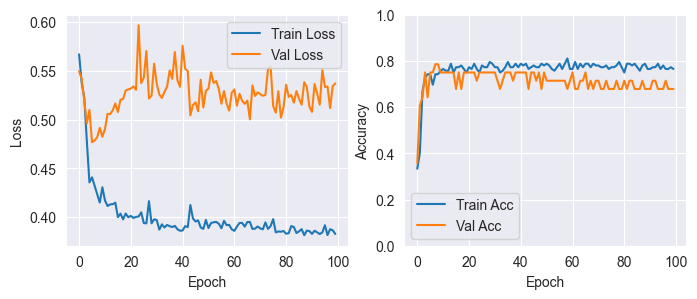

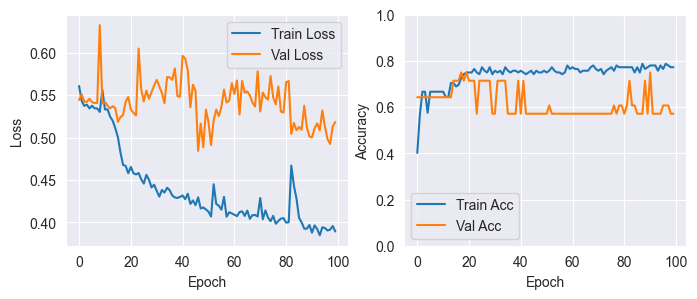

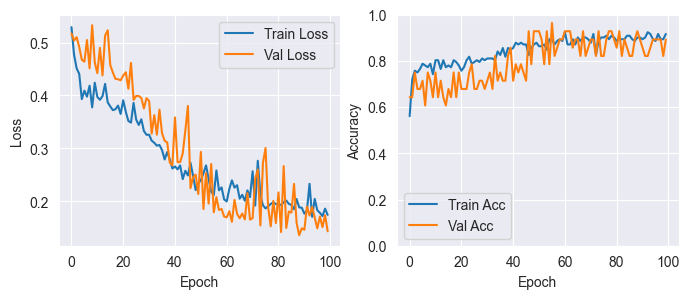

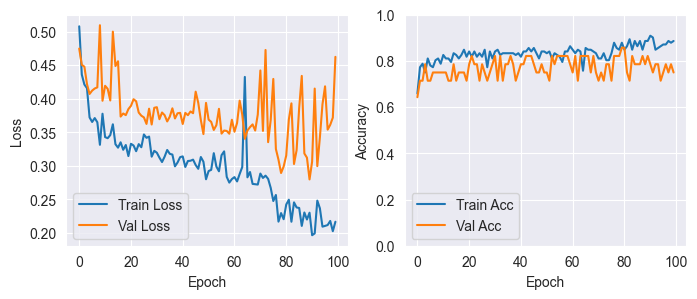

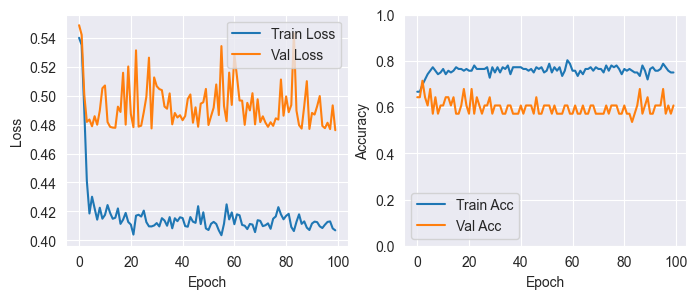

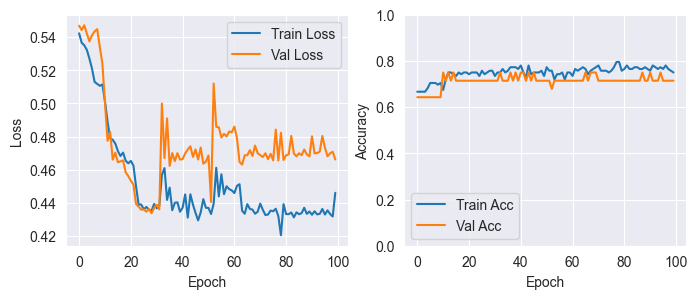

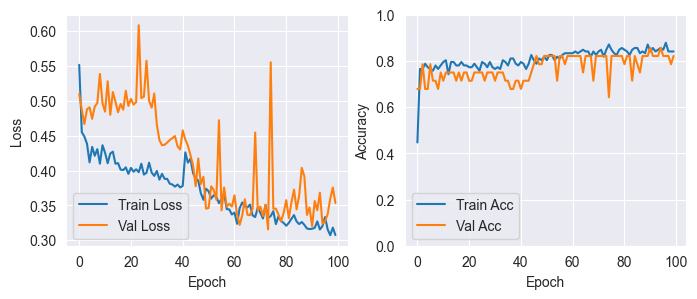

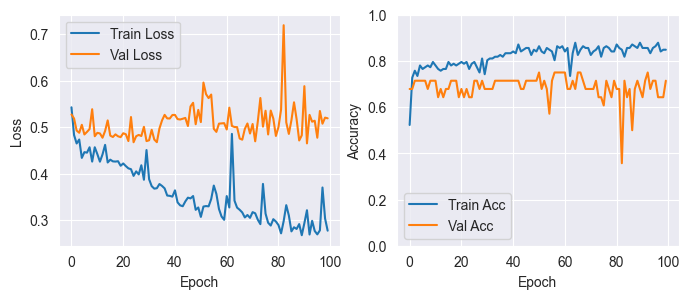

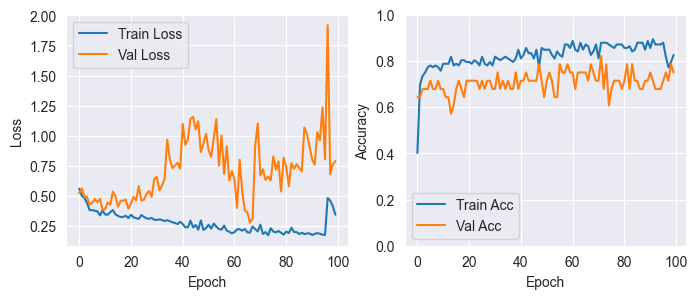

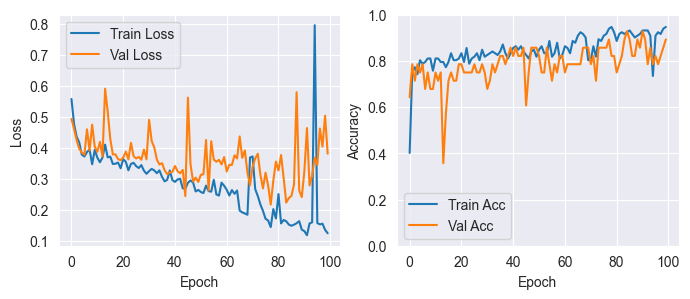

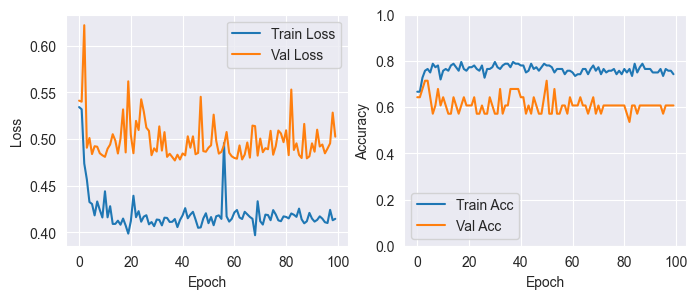

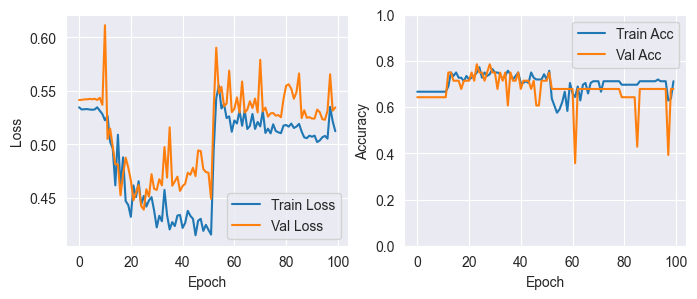

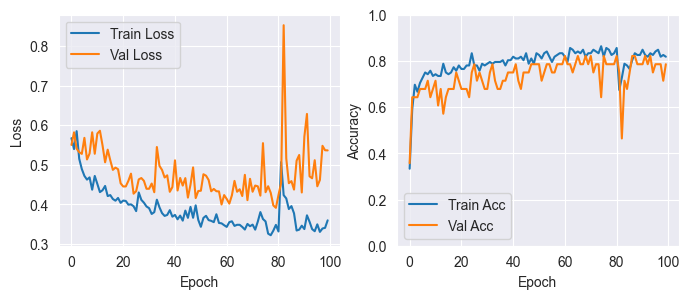

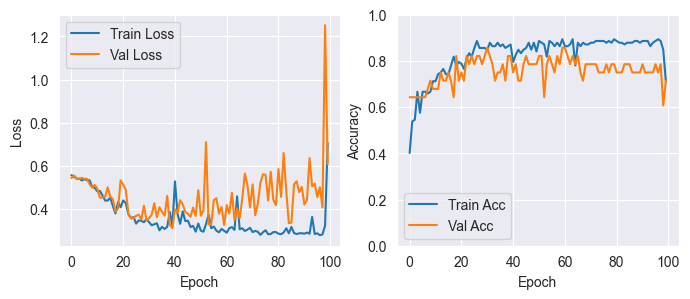

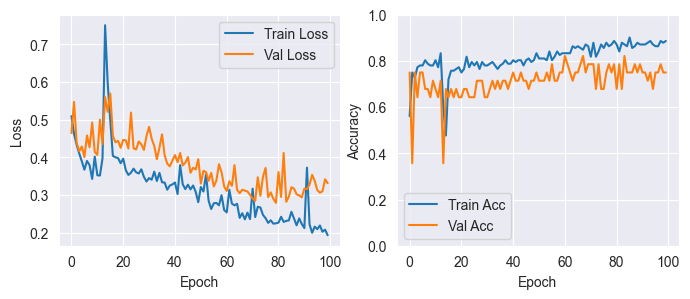

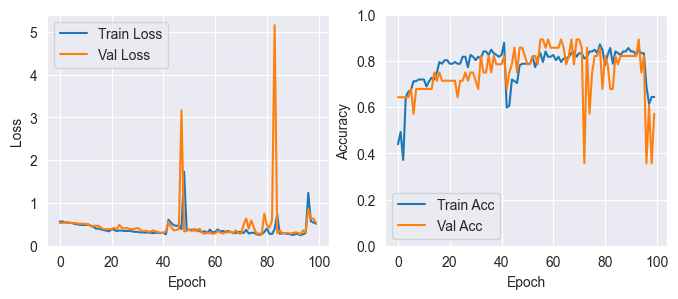

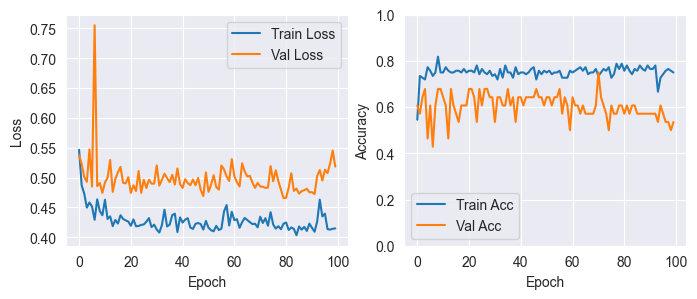

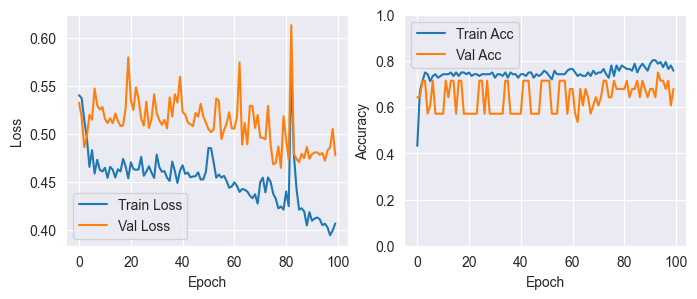

In [42]:
epochs = 100
learning_rate = 1e-2

training_results = {}
for i, model_hyperparams in enumerate(grid_part2):
    # Initialise model and results
    model = GNN(**model_hyperparams)
    training_results[model.uuid] = TR = {}

    # Compute number of trainable parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nModel [{i+1}/{len(grid_part2)}]")
    print(pd.Series(model_hyperparams))

    # Create optimizer and loss
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([train_ratio]))

    # Train model
    start = time.time()
    train_results = train(model, train_loader, val_loader, criterion, optimiser, epochs=epochs, use_edges=False, verbose=1)
    print(f"Training complete. ✅ ({(time.time() - start):.1f}s)")

    # Save model and training results
    TR["model"] = model
    TR["params"] = {**model_hyperparams, "num_params": num_params}
    TR["train_results"] = train_results["train_results"]
    TR["val_results"] = train_results["val_results"]

    # Create training curve
    fig = plot_training_history(train_results)
    fig.savefig(os.path.join(PLOT_PATH, f"training_curve_{model.uuid}.png"))

### Performance Evaluation

*Note, that the performance evaluation of all models is done after the implementation of the edge convolutional layer to have the entire analysis and evaluation in one place.*

## Part 3: Incorporating Edge Features

---


### Strategy for incorporating edge features

The approach taken in this project for including edge features in the graph classification of the mutagenicity of a chemical compound is a simplified version of the **Edge Graph Convolutional Layer**, called $\text{EGGN(C)}$ proposed in the paper [Exploiting Edge Features in Graph Neural Networks](https://arxiv.org/pdf/1809.02709.pdf), *Gong et. al*. 

In a graph $N$ nodes, we define the node feature matrix $\mathbf{H}$ as a $N \times D$ dimensional matrix and the adjancency matrix $\mathbf{A}$ as a $N \times N$ binary matrix. Now, we similarly define the edge feature matrix $\mathbf{E}$ as a $N \times N \times P$ dimensional matrix, where the entry at index $(i, j)$ represents the real-valued, $P$-dimensional edge feature vector of the edge between the $i$-th and $j$-th node. Given this notation it becomes clear that the edge feature matrix $\mathbf{E}$ can be seen as an extension of the adjacency matrix $\mathbf{A}$, where each entry is a $P$-dimensional vector instead of a scalar.

Following the method proposed in the paper and the above notation, we can extend the regular graph convolution in a straight-forward way by treating each dimension of the edge feature vector as a separate *channel* to perform graph convolution over.

$$
H^{(l+1)} = \sigma\left(\sum_{p=1}^P \tilde{\mathbf{E}}_{\cdot\cdot p} \mathbf{H}^{(l)} \mathbf{W}_l + \mathbf{H}^{(l)} \mathbf{B}_l \right),
$$

where $\tilde{E}_{\cdot\cdot p}$ is the $p$-th channel of the normalised edge feature matrix $\mathbf{E}$ and $W_l$ is the trainable weight matrix of the $l$-th layer.

*Note, that this is a simplified version of the method (EGNN(C)) proposed in the paper. I disregard the doubly-stochastic edge normalisation since the edge features are categorical one-hot encoded in our data and thus a regular row normalisation as done in a regular graph convolution should suffice. Further, I include the bias term, which is not done in  the paper.*

In [43]:
class EdgeGraphConv(nn.Module, metaclass=Meta):
    """Edge graph convolutional layer, adapted from the paper "Exploting Edge Features in Graph Neural Networks" (https://arxiv.org/pdf/1611.08945.pdf)."""

    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the edge graph convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        
        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layers
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.bias = nn.Linear(in_features, out_features, bias=False)

        # Non-linear activation function (optional)
        self.activation = activation

    def forward(self, x, e):
        """
        Perform edge graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            e (Tensor): Edge feature matrix of the graph, shape (num_nodes, num_nodes, num_edge_features).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """

        # Neighborhood aggregation based on edge features
        x_agg = torch.zeros((x.shape[0], self.out_features))
        for p in range(e.shape[2]):
            x_agg += self.weight(e[:, :, p] @ x)

        # Graph convolution
        x = x_agg + self.bias(x)

        # Add non-linearity
        if self.activation:
            return self.activation(x)
        return x

In [44]:
# Test EGNN
conv = EdgeGraphConv(3, 2)
out = conv(test_x, test_e)

assert out.shape == (3, 2), f"Output shape shold be 3x2 but is {out.shape}"
assert repr(EdgeGraphConv) == "EdgeGraphConv", f"Class name should be `EdgeGraphConv`, but is {repr(EdgeGraphConv)}"

print("Tests passed. ✅")

Tests passed. ✅


### Hyperparameter Tuning

Let's extend the training results by running the same hyperparameter tuning as before, but now only with the edge convolutional layer. We will append the results to the previous results and compare the performance of the two approaches in the next section.

In [45]:
# Update model hyperparameter grid to include only EGGN
HYPERPARAMS["conv"] = [EdgeGraphConv]
grid_part3 = build_grid(HYPERPARAMS)

print(f"Testing an additional {len(grid_part3)} model configurations")

Testing an additional 6 model configurations



Model [1/6]
num_features                7
conv_dims           [8, 4, 2]
conv            EdgeGraphConv
pooling           MeanPooling
dtype: object


100/100 | Train 0.3462 (80.3%) | Val 0.4077 (75.0%): 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Training complete. ✅ (24.7s)

Model [2/6]
num_features                7
conv_dims           [8, 4, 2]
conv            EdgeGraphConv
pooling            MaxPooling
dtype: object


100/100 | Train 0.2436 (90.9%) | Val 0.7062 (78.6%): 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Training complete. ✅ (25.5s)

Model [3/6]
num_features                7
conv_dims       [16, 8, 4, 2]
conv            EdgeGraphConv
pooling           MeanPooling
dtype: object


100/100 | Train 0.2278 (90.2%) | Val 0.8843 (71.4%): 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


Training complete. ✅ (28.5s)

Model [4/6]
num_features                7
conv_dims       [16, 8, 4, 2]
conv            EdgeGraphConv
pooling            MaxPooling
dtype: object


100/100 | Train 0.4128 (76.5%) | Val 0.4243 (60.7%): 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


Training complete. ✅ (29.0s)

Model [5/6]
num_features                    7
conv_dims       [32, 16, 8, 4, 2]
conv                EdgeGraphConv
pooling               MeanPooling
dtype: object


100/100 | Train 0.2485 (88.6%) | Val 1.1027 (71.4%): 100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


Training complete. ✅ (32.0s)

Model [6/6]
num_features                    7
conv_dims       [32, 16, 8, 4, 2]
conv                EdgeGraphConv
pooling                MaxPooling
dtype: object


100/100 | Train 0.2372 (92.4%) | Val 0.7803 (64.3%): 100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


Training complete. ✅ (32.4s)


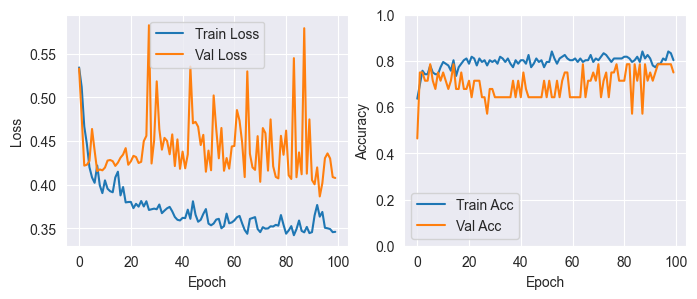

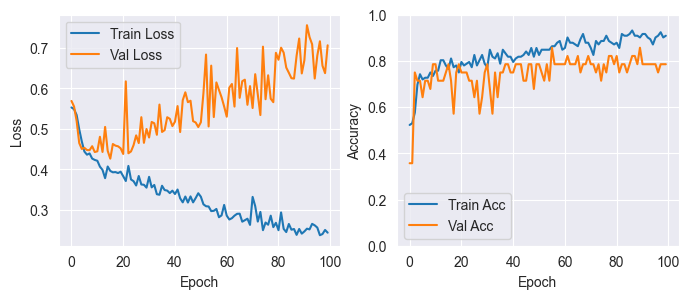

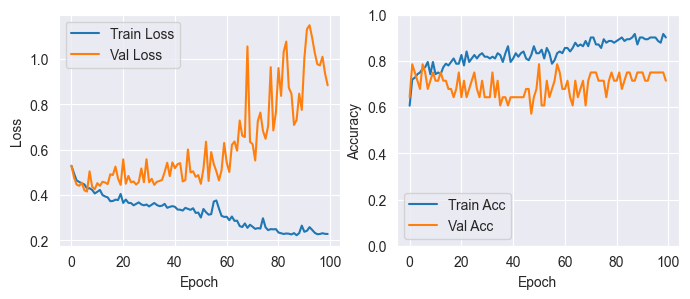

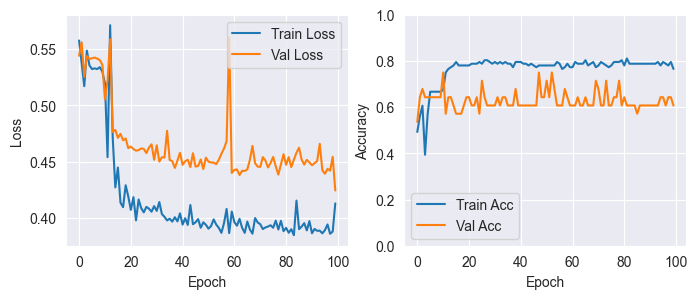

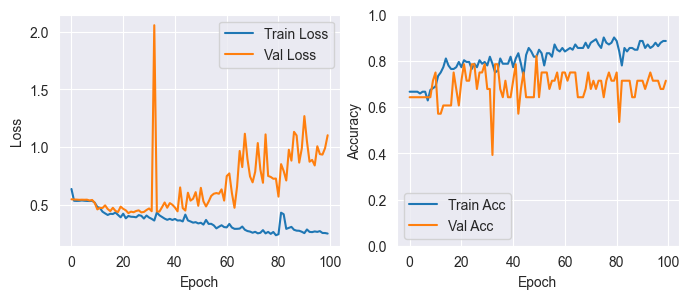

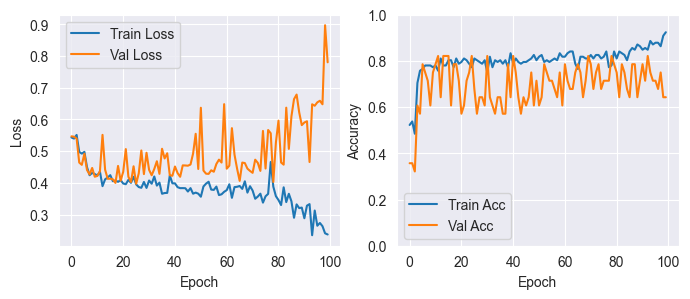

In [46]:
for i, model_hyperparams in enumerate(grid_part3):
    # Initialise model and results
    model = GNN(**model_hyperparams)
    training_results[model.uuid] = TR = {}

    # Compute number of trainable parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nModel [{i+1}/{len(grid_part3)}]")
    print(pd.Series(model_hyperparams))

    # Create optimizer and loss
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([train_ratio]))

    # Train model
    start = time.time()
    train_results = train(model, train_loader, val_loader, criterion, optimiser, epochs=epochs, use_edges=True, verbose=1)
    print(f"Training complete. ✅ ({(time.time() - start):.1f}s)")

    # Save model and training results
    TR["model"] = model
    TR["params"] = {**model_hyperparams, "num_params": num_params}
    TR["train_results"] = train_results["train_results"]
    TR["val_results"] = train_results["val_results"]

    # Create training curve
    fig = plot_training_history(train_results)
    fig.savefig(os.path.join(PLOT_PATH, f"training_curve_{model.uuid}.png"))

### Performance Evaluation

This section evaluates the performance of the different trained models. First, we convert the collected training results to a `pd.DataFrame` and visualise the validation performance (both F1 score and accuracy) as a function of the hyperparameters we have defined, i.e. the number of layers (total number of parameters) and the type of convolutional and pooling layer.

After selecting the best performing model, we retrain the same model configuration on the combined training and validation split and report the final performance on the test split.

In [47]:
def view_training_results(training_results, include_columns):
    """
    Utility function for putting collected training results in a multi-indexed pd.DataFrame.
    """

    # Transform dictionary
    data = {}
    for m in training_results.keys():
        data[m] = {}
        for c in training_results[m].keys():
            if c in include_columns:
                for p in training_results[m][c].keys():
                    if p in include_columns[c]:
                        data[m][(c, p)] = training_results[m][c][p]

    # Create multi-indexed dataframe
    training_results = pd.DataFrame.from_dict(data, orient="index")
    multi_indexed_columns = pd.MultiIndex.from_tuples(training_results.columns)
    training_results.columns = multi_indexed_columns

    # Sort by validation F1 score
    training_results = training_results.sort_values(by=("val_results", "f1"), ascending=False)

    # Filter columns
    include_columns = [(k, c) for k in include_columns.keys() for c in include_columns[k]]
    training_results = training_results[include_columns]

    return training_results

In [48]:
# Convert to LaTeX for report
def results_to_latex(results):
    """
    Utility function for converting training results DataFrame to LaTeX table.
    """
    columns = [("params", "conv_dims"), ("params", "conv"), ("params", "pooling"), ("val_results", "f1"), ("val_results", "accuracy")]
    results = results[columns]
    results = results.reset_index().drop(columns="index")

    # Rename columns
    shorten_conv = {
        "GraphConv": "GraphConv",
        "GraphSAGEConv": "GraphSAGE",
        "AttentionGraphConvolution": "GraphAttention",
        "EdgeGraphConv": "EdgeConv",
    }
    shorten_pool = {
        "MeanPooling": "Mean",
        "MaxPooling": "Max",
    }

    results[("params", "conv")] = results[("params", "conv")].apply(lambda x: shorten_conv[x.__name__])
    results[("params", "pooling")] = results[("params", "pooling")].apply(lambda x: shorten_pool[x.__name__])

    results[("val_results", "f1")] = 100 * results[("val_results", "f1")]
    results[("val_results", "accuracy")] = 100 * results[("val_results", "accuracy")]

    results = results.style.format(precision=2)

    return results.to_latex()

Let's view the training results first by showing a subset of the recorded meta information and performance metrics for all runs in a `pd.DataFrame`.

In [49]:
include_columns = {
    "params": ["num_features", "conv_dims", "conv", "pooling", "num_params"],
    "train_results": ["loss", "accuracy"],
    "val_results": ["loss", "accuracy", "precision", "recall", "f1"],
}

training_results_df = view_training_results(training_results, include_columns)
training_results_df

params                     \
                                 num_features          conv_dims   
65398ab744214be0a1b3a5d0270a521c            7      [16, 8, 4, 2]   
53b9d1834ff54546bb2308f8ecc259bc            7          [8, 4, 2]   
0cf09129c89c4d6faa2d5130446dc165            7      [16, 8, 4, 2]   
98c182b97c6642459625416bd33f5570            7          [8, 4, 2]   
18202954ce8b4907a269072cc33c1b8e            7  [32, 16, 8, 4, 2]   
833a46a41ca14cc191c96131af856637            7  [32, 16, 8, 4, 2]   
a70cfe02848e4590937a76e57535a283            7          [8, 4, 2]   
63a82d976d634ff4946000358b279696            7          [8, 4, 2]   
7cabe8448fae441ab0f32797da424129            7      [16, 8, 4, 2]   
b34f28cd1d284123808043a0bc7c6bdd            7      [16, 8, 4, 2]   
73669136c0524c4c946cb7c9dd78422a            7  [32, 16, 8, 4, 2]   
a941396a58e345d197b2d214aaac9440            7          [8, 4, 2]   
20e473c7851b45c88600c2c4b27e3d06            7      [16, 8, 4, 2]   
b2c8e6714689464f9522fa3b010c5f83            7  [32, 16, 8, 4, 2]   
23b8d61347e54f93a5b4426e11d63471            7  [32, 16, 8, 4, 2]   
3f7a2158f73c4c36bd52d1587abe431f            7          [8, 4, 2]   
2490c2c9e00c44bf870666342ee426eb            7  [32, 16, 8, 4, 2]   
1ba232598db0431585d149a7711f2281            7      [16, 8, 4, 2]   
e89f7b7ee25945c984f3bdf3a8d1e5af            7      [16, 8, 4, 2]   
020455a062414c678d4eb08274c1bd2f            7          [8, 4, 2]   
05b73968c0a44fb3a3d5a316b5dd52f8            7          [8, 4, 2]   
4125b4c094cd41618693f9b82e4c16c0            7  [32, 16, 8, 4, 2]   
2ab584b7c9b54447a819193f811d5aef            7  [32, 16, 8, 4, 2]   
2ae680a6f2624e7d9d332a6b90b102d3            7      [16, 8, 4, 2]   

                                                                          \
                                                       conv      pooling   
65398ab744214be0a1b3a5d0270a521c              GraphSAGEConv   MaxPooling   
53b9d1834ff54546bb2308f8ecc259bc              GraphSAGEConv  MeanPooling   
0cf09129c89c4d6faa2d5130446dc165                  GraphConv  MeanPooling   
98c182b97c6642459625416bd33f5570              EdgeGraphConv   MaxPooling   
18202954ce8b4907a269072cc33c1b8e                  GraphConv  MeanPooling   
833a46a41ca14cc191c96131af856637              GraphSAGEConv  MeanPooling   
a70cfe02848e4590937a76e57535a283              GraphSAGEConv   MaxPooling   
63a82d976d634ff4946000358b279696              EdgeGraphConv  MeanPooling   
7cabe8448fae441ab0f32797da424129                  GraphConv   MaxPooling   
b34f28cd1d284123808043a0bc7c6bdd              GraphSAGEConv  MeanPooling   
73669136c0524c4c946cb7c9dd78422a              EdgeGraphConv  MeanPooling   
a941396a58e345d197b2d214aaac9440  AttentionGraphConvolution   MaxPooling   
20e473c7851b45c88600c2c4b27e3d06              EdgeGraphConv  MeanPooling   
b2c8e6714689464f9522fa3b010c5f83                  GraphConv   MaxPooling   
23b8d61347e54f93a5b4426e11d63471  AttentionGraphConvolution   MaxPooling   
3f7a2158f73c4c36bd52d1587abe431f                  GraphConv  MeanPooling   
2490c2c9e00c44bf870666342ee426eb              EdgeGraphConv   MaxPooling   
1ba232598db0431585d149a7711f2281  AttentionGraphConvolution  MeanPooling   
e89f7b7ee25945c984f3bdf3a8d1e5af              EdgeGraphConv   MaxPooling   
020455a062414c678d4eb08274c1bd2f  AttentionGraphConvolution  MeanPooling   
05b73968c0a44fb3a3d5a316b5dd52f8                  GraphConv   MaxPooling   
4125b4c094cd41618693f9b82e4c16c0  AttentionGraphConvolution  MeanPooling   
2ab584b7c9b54447a819193f811d5aef              GraphSAGEConv   MaxPooling   
2ae680a6f2624e7d9d332a6b90b102d3  AttentionGraphConvolution   MaxPooling   

                                            train_results           \
                                 num_params          loss accuracy   
65398ab744214be0a1b3a5d0270a521c        563          0.12     0.95   
53b9d1834ff54546bb2308f8ecc259bc        195          0.17     0.92   
0cf09129c89c4

Interesting! Let's try to visualise the performance of the best performing model as a function of the hyper-parameters.

We start by looking at each hyper-parameter individually and plot the aggregated validation performance.

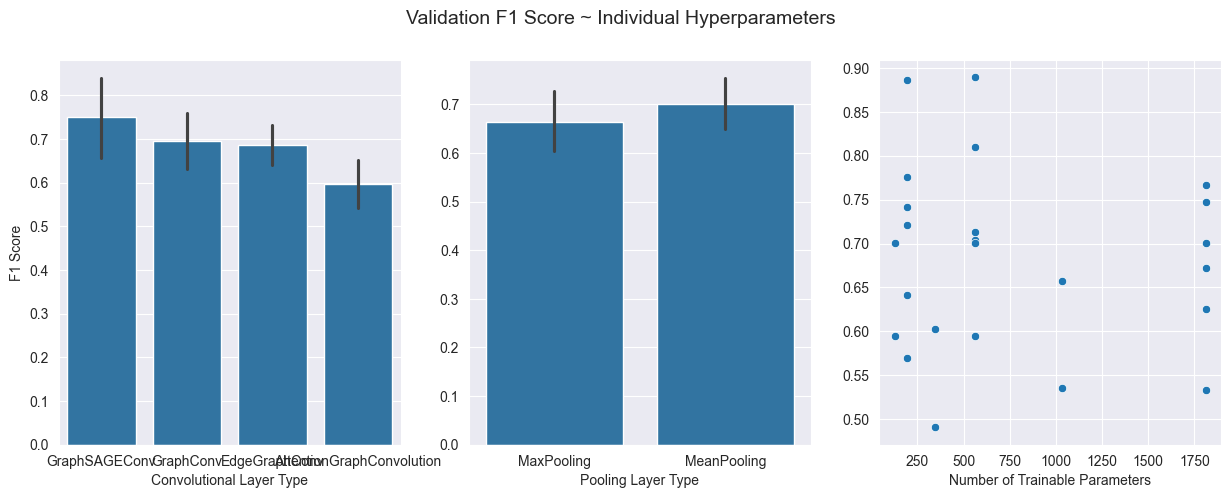

In [50]:
# Create figure with subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

# Plot validation performance as function of number of convolutional layer type
sns.barplot(training_results_df, x=("params", "conv"), y=("val_results", "f1"), ax=axs[0]);
axs[0].set(
    xlabel="Convolutional Layer Type",
    ylabel="F1 Score",
);

# Plot validation performance as function of number of convolutional layer type
sns.barplot(training_results_df, x=("params", "pooling"), y=("val_results", "f1"), ax=axs[1]);
axs[1].set(
    xlabel="Pooling Layer Type",
    ylabel="",
);

# Plot validation performance as function of number of convolutional layer type
sns.scatterplot(training_results_df, x=("params", "num_params"), y=("val_results", "f1"), ax=axs[2]);
axs[2].set(
    xlabel="Number of Trainable Parameters",
    ylabel="",
);
fig.suptitle("Validation F1 Score ~ Individual Hyperparameters", fontsize=14);

# Save figure
fig.savefig(os.path.join(PLOT_PATH, "perf_vs_hyperparms.png"), dpi=300)

Nice! Let's try to look at a more dense representation using a scatter plot that relates the number of parameters to the validation performance. Additionally, we encode the convolutional layer type through hue and the global pooling type through different shapes 

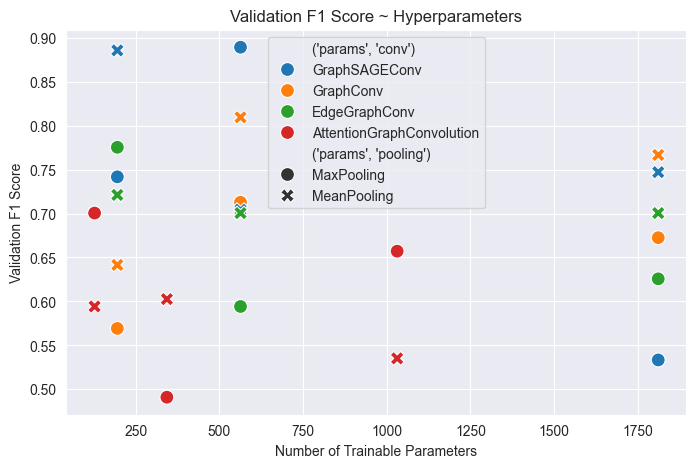

In [56]:
# Scatterplot of 
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(training_results_df, 
                x=("params", "num_params"), 
                y=("val_results", "f1"), 
                hue=("params", "conv"), 
                style=("params", "pooling"), 
                markers=True, 
                s=100,
                ax=ax);

ax.set(
    title="Validation F1 Score ~ Hyperparameters",
    xlabel="Number of Trainable Parameters",
    ylabel="Validation F1 Score",
);

# Save figure
fig.savefig(os.path.join(PLOT_PATH, "perf_vs_hyperparms_scatter.png"), dpi=300)

### Final Model

Finally, let's use the best performing model and evaluate it on the test set.

In [52]:
# Best model
best_model_idx = training_results_df[("val_results", "f1")].argmax()
best_model_info = training_results_df.iloc[best_model_idx]

best_model = training_results[best_model_info.name]["model"]

# Print best model's hyperparameters
best_model_info[["params", "val_results"]]

params       num_features                7
             conv_dims       [16, 8, 4, 2]
             conv            GraphSAGEConv
             pooling            MaxPooling
             num_params                563
val_results  loss                     0.38
             accuracy                 0.89
             precision                0.88
             recall                   0.92
             f1                       0.89
Name: 65398ab744214be0a1b3a5d0270a521c, dtype: object

In [53]:
# Test best model
test_results = validate(best_model, test_loader, criterion, verbose=True)

              precision    recall  f1-score   support

         0.0       0.73      0.89      0.80         9
         1.0       0.94      0.84      0.89        19

    accuracy                           0.86        28
   macro avg       0.83      0.87      0.84        28
weighted avg       0.87      0.86      0.86        28



In [54]:
# Print numeric test results
print("Test results")
pd.Series(test_results)

Test results


loss                             0.21
accuracy                         0.86
precision                        0.83
recall                           0.87
f1                               0.84
confusion_matrix    [[8, 1], [3, 16]]
dtype: object

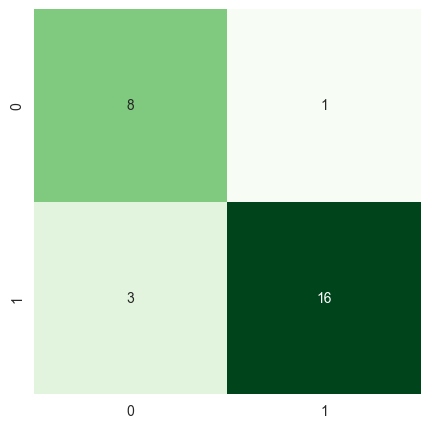

In [55]:
# Print out heatmap of confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(test_results["confusion_matrix"], annot=True, fmt="d", cmap="Greens", cbar=False, ax=ax);

fig.savefig(os.path.join(PLOT_PATH, "confusion_matrix.png"), dpi=300)